# TP1 Machine Learning


## I. Réduction de dimensions et Visualisation des données

Dans cet atelier pratique, vous allez expérimenter des algorithmes de traitement de données pour répondre à
différents problèmes liés à l’apprentissage non supervisé avec le langage Python.


Le fichier **villes.csv** comporte 32 villes françaises décrites par les températures moyennes dans les 12 mois de
l’année.
L’objectif dans cette partie est de représenter graphiquement le plus d’informations possibles contenues dans
ce fichier de données et de déceler une éventuelle segmentation topologique des villes.

In [1]:
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # importation du module PCA 
from itertools import combinations
import matplotlib

Le fichier ***villes.csv*** comporte 32 villes françaises décrites par les températures moyennes dans les 12 mois de
l’année.
L’objectif dans cette partie est de représenter graphiquement le plus d’informations possibles contenues dans
ce fichier de données et de déceler une éventuelle segmentation topologique des villes.

In [2]:
# 1. Importer ce jeu de données avec la librairie pandas (c.f. read_csv) 
data = pd.read_csv('./villes.csv', sep=';')
X = data.iloc[:, 1:13].values  # tableau avec les données température
labels = data.iloc[:, 0].values # tableau avec les nom des villes



## Analyse en Composantes Principale
2. Réaliser une **Analyse en Composantes Principales** (module `PCA` de `Scikit-learn`) sur ce jeu de données
centrées réduites `StandardScaler`

• Quel est le nombre d’axes à retenir pour conserver une bonne quantité de l’information
représentée dans le nuage initial.

• Donner une interprétation des deux premiers axes principaux.

• En suivant le code suivant, donner une visualisation graphique des villes projetées dans le plan
principal.

`X_pca` étant la matrice des données transformées par l’**ACP**, labels étant le vecteur contenant le nom
des instances (ici les villes).


### Centrage et réduction
Utilisation StandardScaler pour assurer que toutes les variables ont la même influence dans l'**ACP**, peu importe leur échelle initiale.



In [3]:

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer l'ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


### Variance expliquée cumulée
Le tableau `explained_variance` permet de visualiser la proportion de variance expliquée par chaque axe principal. Par exemple, si les deux premiers axes expliquent **90%** de la variance cumulée, on peut retenir ces deux axes.


In [4]:
# Variance expliquée et variance cumulée
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


### Interprétation des axes principaux



In [5]:
# Déterminer le nombre d'axes à retenir (par exemple : 90 % de la variance)
n_components = np.argmax(explained_variance >= 0.9) + 1
print(f"Nombre d'axes retenus : {n_components}")

Nombre d'axes retenus : 1


In [6]:
# Poids des variables sur les deux premiers axes principaux
principal_axes = pd.DataFrame(
    pca.components_[:2],
    columns=data.columns[1:13],
    index=["PC1", "PC2"]
)
print("Poids des variables sur les deux premiers axes principaux :\n", principal_axes)

Poids des variables sur les deux premiers axes principaux :
          janv       fev      mars     avril       mai      juin      juil  \
PC1  0.271510  0.288462  0.301081  0.303542  0.283531  0.278419  0.272903   
PC2  0.399335  0.299072  0.129431 -0.115306 -0.323143 -0.358468 -0.388796   

         aout      sept       oct       nov       dec  
PC1  0.287578  0.304720  0.303855  0.292428  0.272955  
PC2 -0.301013 -0.112316  0.122492  0.262695  0.386937  


## Visualisation dans le plan principal
La visualisation avec `plt.scatter` projette les données dans l’espace réduit à deux dimensions, tout en permettant une annotation des points pour une meilleure interprétation.

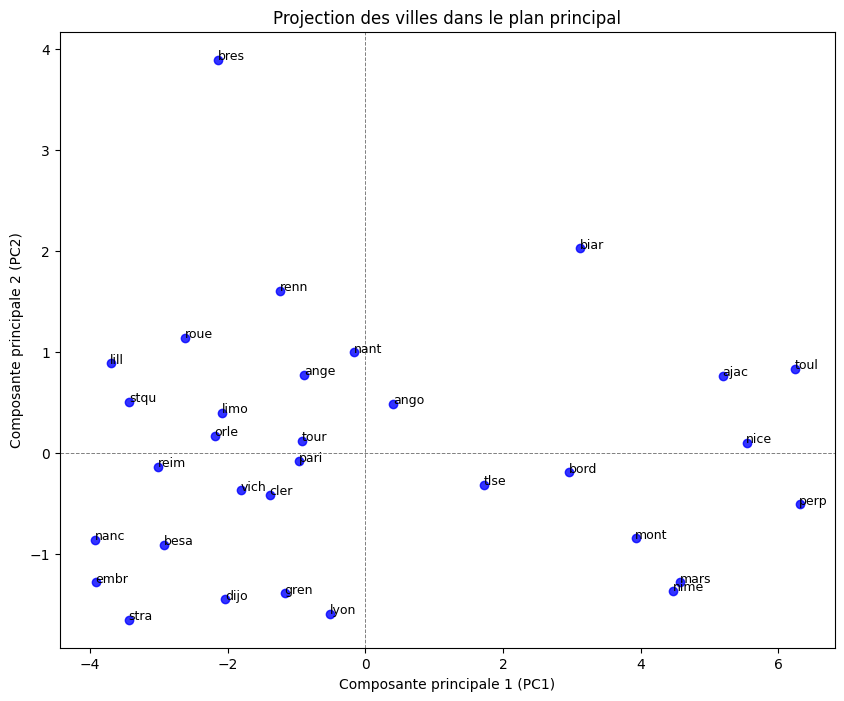

In [7]:
# Visualisation des données dans le plan principal
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.8, color='blue')

# Annotation des points
for label, x, y in zip(labels, X_pca[:, 0], X_pca[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points', fontsize=9)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)
plt.xlabel("Composante principale 1 (PC1)")
plt.ylabel("Composante principale 2 (PC2)")
plt.title("Projection des villes dans le plan principal")
plt.show()

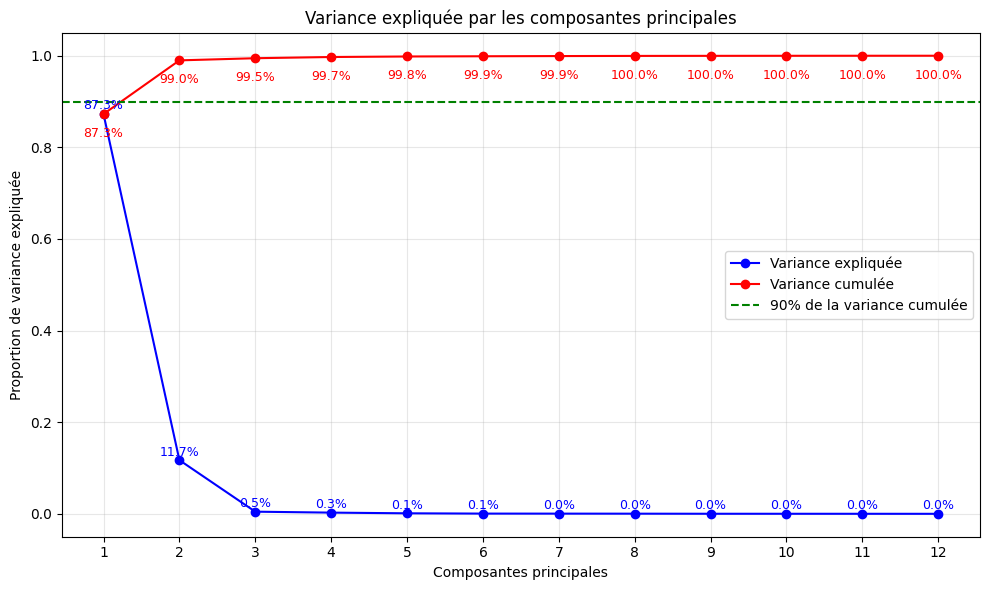

In [8]:

# Création du graphe linéaire
plt.figure(figsize=(10, 6))

# Ligne pour la variance expliquée par composante
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Variance expliquée', color='blue')

# Ligne pour la variance cumulée
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label='Variance cumulée', color='red')

# Ajouter des annotations (pourcentages)
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance), start=1):
    plt.text(i, var + 0.01, f"{var*100:.1f}%", ha='center', fontsize=9, color='blue')
    plt.text(i, cum_var - 0.05, f"{cum_var*100:.1f}%", ha='center', fontsize=9, color='red')

# Personnalisation du graphique
plt.xticks(range(1, len(explained_variance) + 1))
plt.xlabel('Composantes principales')
plt.ylabel('Proportion de variance expliquée')
plt.title('Variance expliquée par les composantes principales')
plt.axhline(0.9, color='green', linestyle='--', label='90% de la variance cumulée')
plt.legend(loc='best')
plt.grid(alpha=0.3)

# Affichage du graphique
plt.tight_layout()
plt.show()


Création d'une fonction générique qui prendra en entrée différents fichiers CSV  et effectuera l'Analyse en Composantes Principales (ACP) pour chaque fichier, tout en traçant les graphiques de la variance expliquée pour chaque jeu de données.

In [23]:

def fonction_tp_pca(file_path, sep=';', label_column=0, data_columns=slice(1, None), threshold=0.9):
    """
    Fonction pour réaliser l'ACP sur un jeu de données et tracer la variance expliquée par les axes principaux,
    ainsi que les projections des points dans des graphiques 2D et 3D.
    
    Parameters:
    - file_path : str : Chemin du fichier CSV à charger
    - sep : str : Délimiteur du fichier CSV (par défaut ';')
    - label_column : int : Index de la colonne contenant les labels (noms des villes)
    - data_columns : slice : Index des colonnes contenant les données numériques
    - threshold : float : Seuil de variance cumulée pour déterminer le nombre d'axes à retenir (par défaut 90%)


    """
    
    # Charger le fichier CSV
    data = pd.read_csv(file_path, sep=sep)
    
    # Extraire les données et labels
    X = data.iloc[:, data_columns].values
    labels = data.iloc[:, label_column].values
    
    # Centrer et réduire les données
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Appliquer l'ACP
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # Calculer la variance expliquée et la variance cumulée
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    # Tracer la variance expliquée et cumulée
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Variance expliquée', color='blue')
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label='Variance cumulée', color='red')
    plt.axhline(threshold, color='green', linestyle='--', label=f'{threshold*100}% de la variance cumulée')
    plt.xlabel('Composantes principales')
    plt.ylabel('Proportion de variance expliquée')
    plt.title('Variance expliquée par les composantes principales')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Retourner le nombre de composantes principales nécessaires pour atteindre le seuil de variance cumulée
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"Nombre de composantes principales à retenir : {n_components}")
    
    # Tracé en 3D pour les trois premières composantes principales (si au moins 3 composantes)
    if (n_components) >= 3:
        fig = plt.figure(figsize=(15, 12))
        ax = fig.add_subplot(111, projection='3d')
        
        # Points dans l'espace 3D
        ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], alpha=0.8, color='blue')
        
        # Annotation des points
        for label, x, y, z in zip(labels, X_pca[:, 0], X_pca[:, 1], X_pca[:, 2]):
            ax.text(x, y, z, label, fontsize=9)
        
        # Étiquettes des axes
        ax.set_xlabel("Composante principale 1 (PC1)")
        ax.set_ylabel("Composante principale 2 (PC2)")
        ax.set_zlabel("Composante principale 3 (PC3)")
        ax.set_title("Projection des villes dans l'espace tridimensionnel")
        
        plt.show()
    else:
            
    
        columns = data.columns[data_columns]
        for (i, j) in combinations(range(n_components), 2):  # Combinaisons 2 à 2 des axes
            principal_axes = pd.DataFrame(
                pca.components_[[i, j]],
                columns=columns,
                index=[f"PC{i+1}", f"PC{j+1}"]
            )
            print(f"\nPoids des variables sur les axes {i+1} et {j+1} (PC{i+1} et PC{j+1}) :\n", principal_axes)
            
            # Visualisation des données dans le plan (PCi, PCj)
            plt.figure(figsize=(10, 8))
            plt.scatter(X_pca[:, i], X_pca[:, j], alpha=0.8, color='blue')
            
            # Annotation des points
            for label, x, y in zip(labels, X_pca[:, i], X_pca[:, j]):
                plt.annotate(label, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points', fontsize=9)
            
            # Ajouter des lignes de référence
            plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
            plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)
            plt.xlabel(f"Composante principale {i+1} (PC{i+1})")
            plt.ylabel(f"Composante principale {j+1} (PC{j+1})")
            plt.title(f"Projection des données dans le plan principal (PC{i+1} vs PC{j+1})")
            plt.show()
    
    return n_components, X_scaled,  X_pca


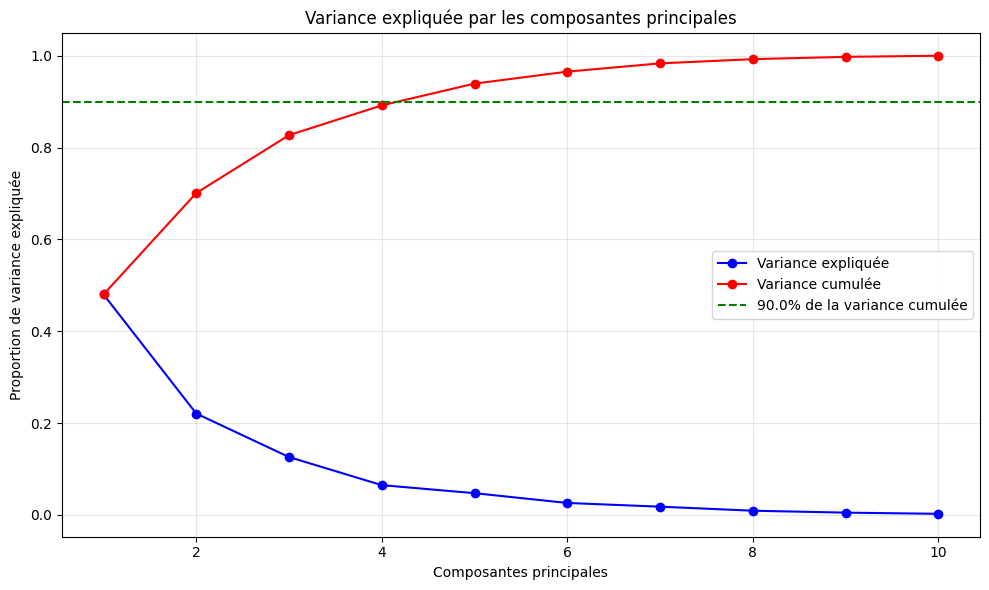

Nombre de composantes principales à retenir : 5


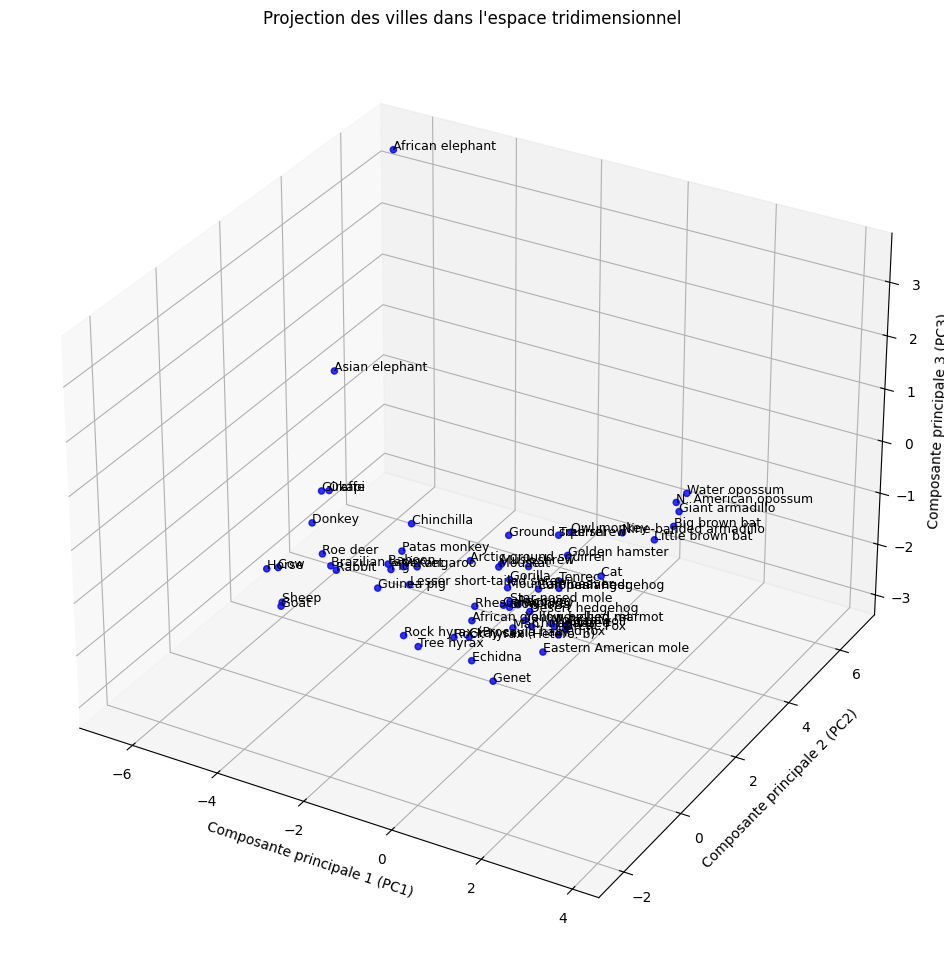

In [27]:
fonction_tp_pca('./mammals.csv', sep=';', label_column=0, data_columns=slice(1, None))


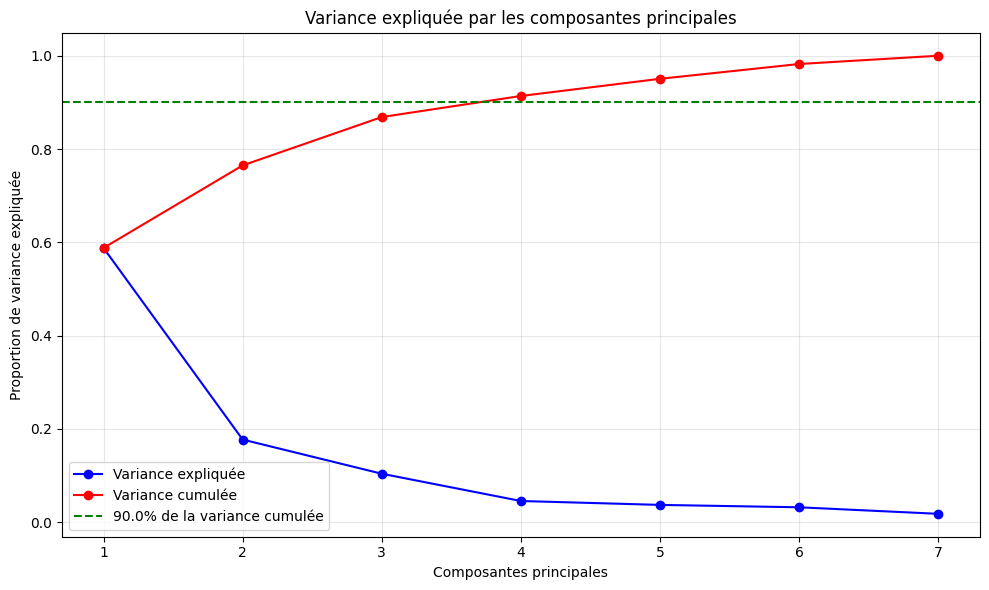

Nombre de composantes principales à retenir : 4


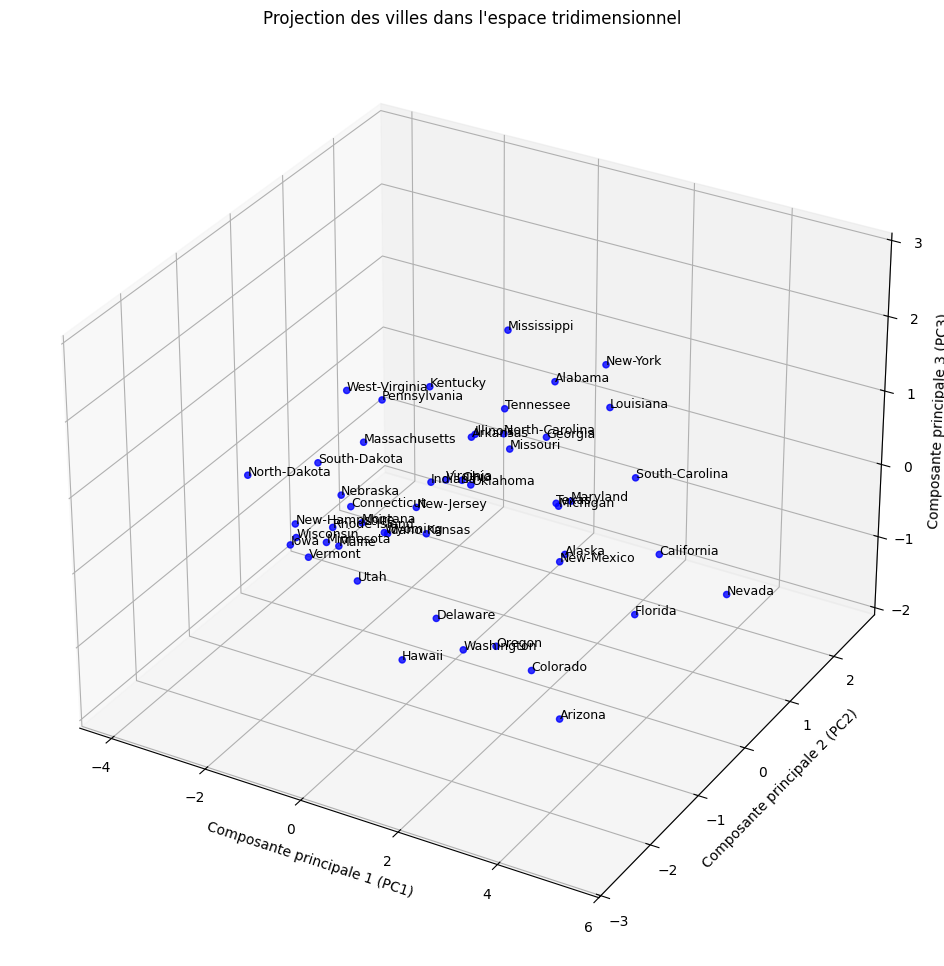

np.int64(4)

In [80]:
fonction_tp_pca('./crimes.csv', sep=';', label_column=0, data_columns=slice(1, None))

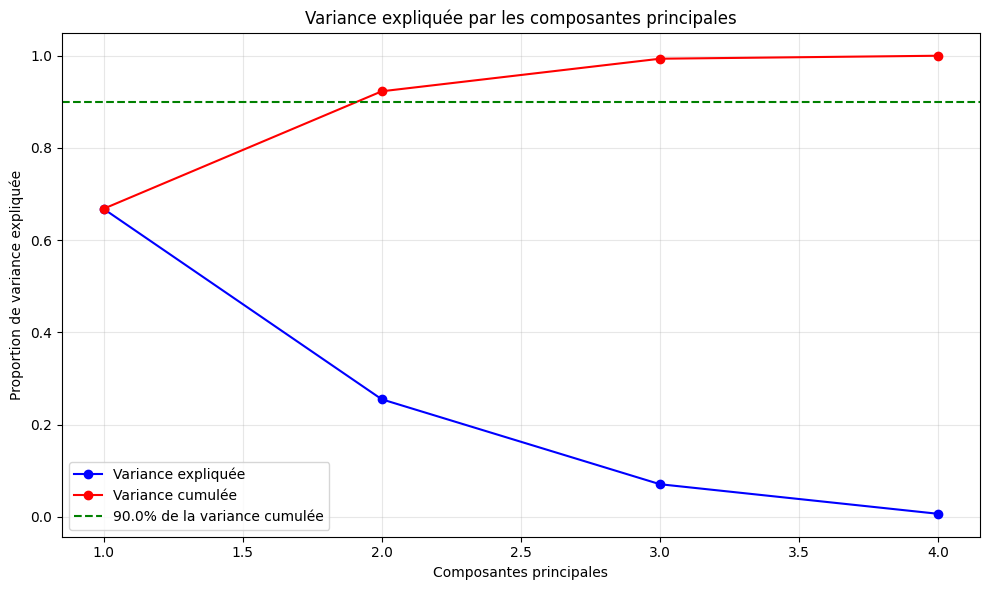

Nombre de composantes principales à retenir : 2

Poids des variables sur les axes 1 et 2 (PC1 et PC2) :
      Depenses R&D  Depenses Administration  Depenses Marketing Spend  Benefice
PC1      0.593479                 0.147379                  0.520647  0.595810
PC2      0.040481                 0.950513                 -0.307971 -0.006321


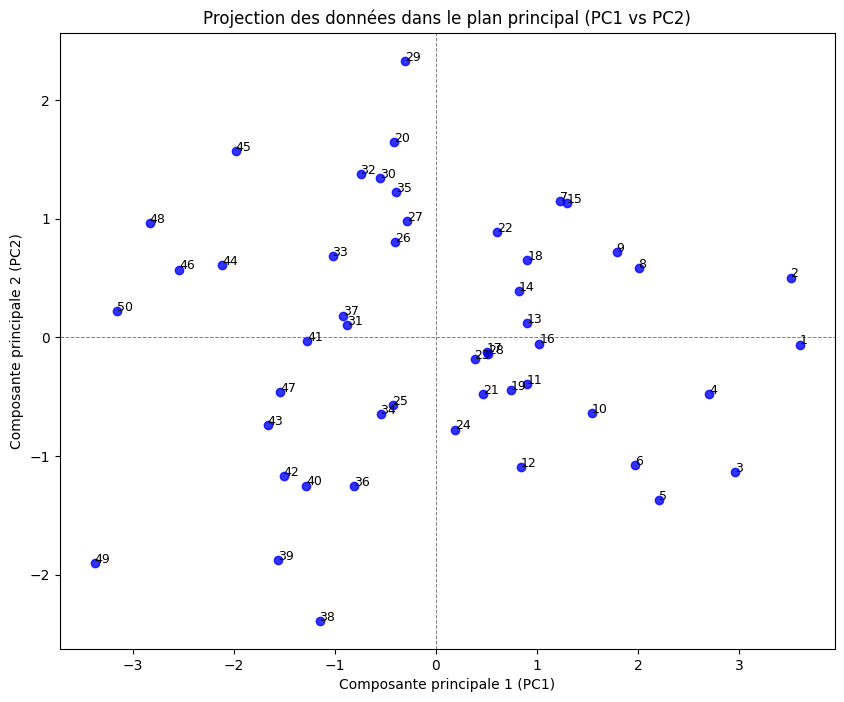

np.int64(2)

In [81]:
fonction_tp_pca('./50_Startups.csv', sep=';', label_column=0, data_columns=slice(1, None))

## II Clustering

Nous allons étudier dans la suite deux approches de clustering (k-moyennes **KMeans** et la classification
Ascendante Hiérarchique **AgglomerativeClustering** du package `sklearn.cluster`) que nous allons appliquer sur
le jeu de données des **villes**.


In [9]:
from sklearn.cluster import KMeans

In [10]:
# Appliquer KMeans avec 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clustering = kmeans.fit_predict(X_pca)

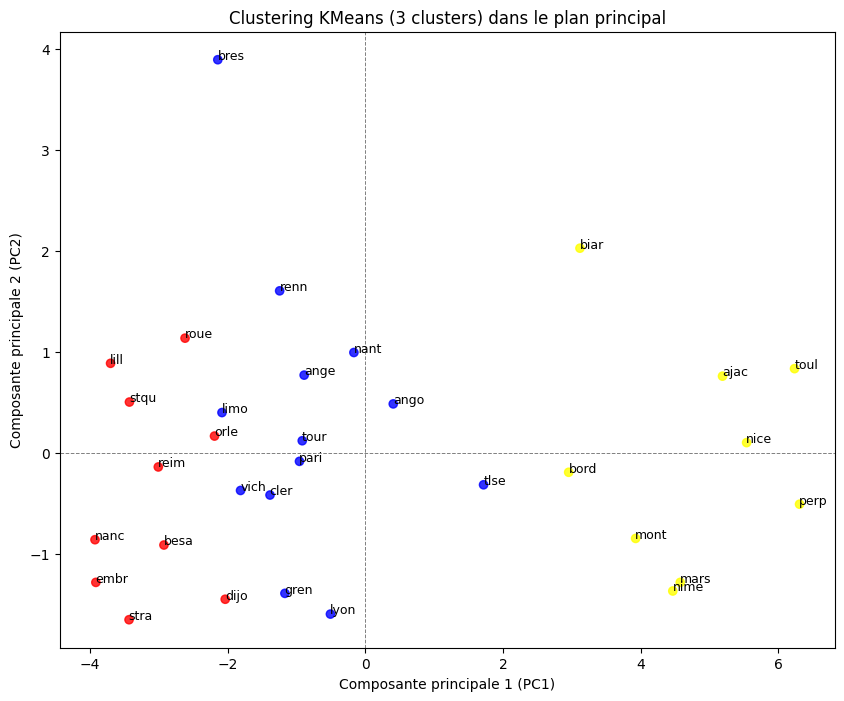

In [13]:
# Visualisation des clusters dans le plan principal
colors = ['red', 'yellow', 'blue']  # Définir les couleurs pour chaque cluster
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustering, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.8)

# Ajouter les annotations (noms des villes)
for label, x, y in zip(labels, X_pca[:, 0], X_pca[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points', fontsize=9)

# Ajouter des lignes de référence et des informations au graphique
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)
plt.xlabel("Composante principale 1 (PC1)")
plt.ylabel("Composante principale 2 (PC2)")
plt.title("Clustering KMeans (3 clusters) dans le plan principal")
plt.show()


Appliquez la procédure **AgglomerativeClustering** sur ce jeu de données pour obtenir trois clusters avec
différentes méthodes d’agrégation.

In [14]:
from sklearn.cluster import AgglomerativeClustering

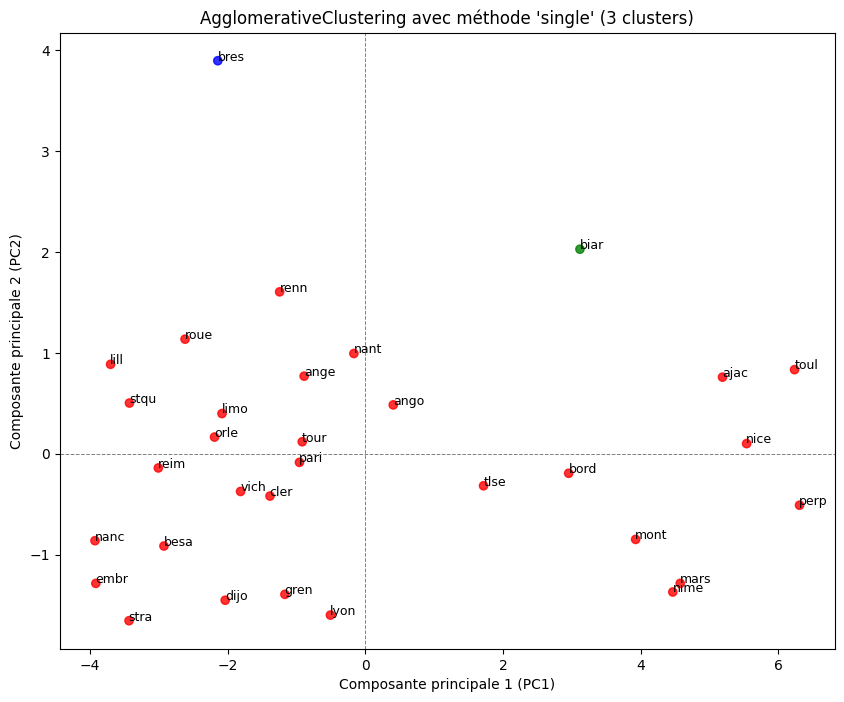

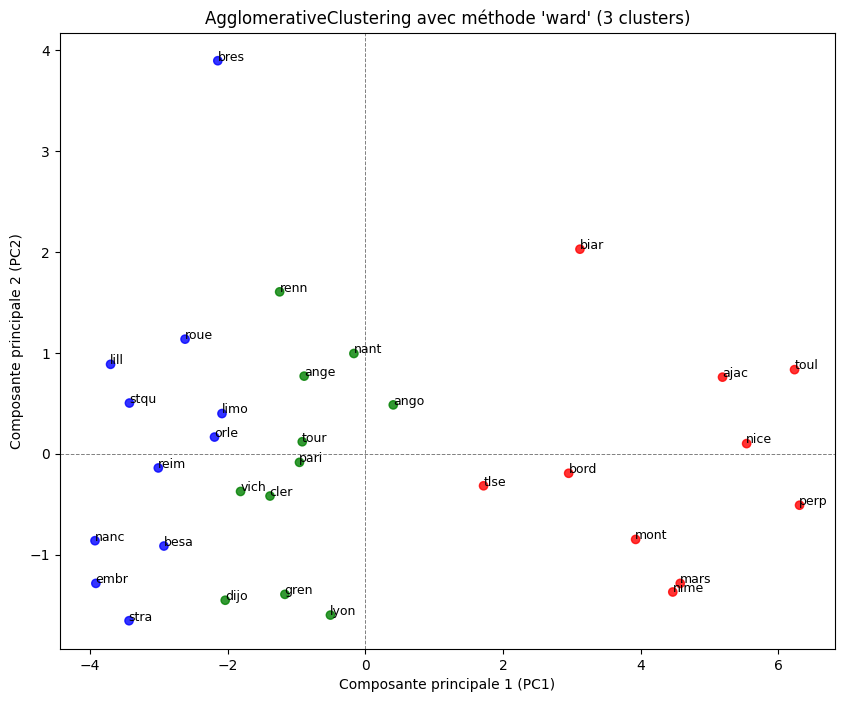

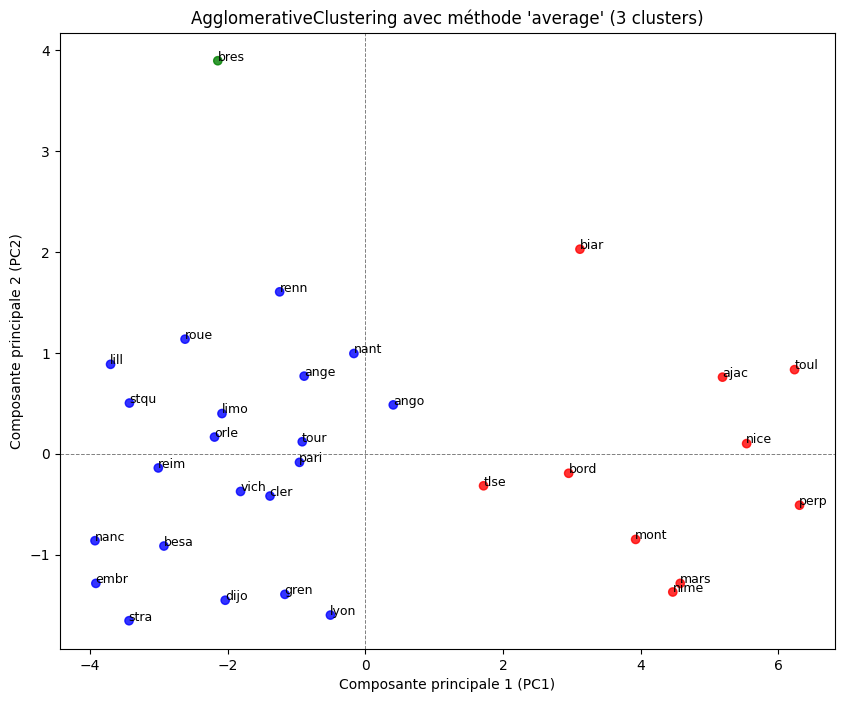

In [19]:
# Appliquer AgglomerativeClustering avec différentes méthodes
methods = ['single', 'ward', 'average']
colors = ['red', 'yellow', 'blue', 'pink', 'green']  # Adapter les couleurs pour plus de clusters
for method in methods:
    # Clustering avec la méthode spécifiée
    clustering = AgglomerativeClustering(n_clusters=3, linkage=method).fit_predict(X_scaled)
    
    # Visualisation des clusters dans le plan principal
    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustering, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.8)
    
    # Ajouter les annotations (noms des villes)
    for label, x, y in zip(labels, X_pca[:, 0], X_pca[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points', fontsize=9)
    
    # Ajouter des lignes de référence et des informations au graphique
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)
    plt.xlabel("Composante principale 1 (PC1)")
    plt.ylabel("Composante principale 2 (PC2)")
    plt.title(f"AgglomerativeClustering avec méthode '{method}' (3 clusters)")
    plt.show()


In [20]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

KMeans avec 2 clusters :
 - Indice de silhouette : 0.626
 - Indice de Davies-Bouldin : 0.513

KMeans avec 3 clusters :
 - Indice de silhouette : 0.374
 - Indice de Davies-Bouldin : 0.896

KMeans avec 4 clusters :
 - Indice de silhouette : 0.310
 - Indice de Davies-Bouldin : 1.080

KMeans avec 5 clusters :
 - Indice de silhouette : 0.301
 - Indice de Davies-Bouldin : 1.018

KMeans avec 6 clusters :
 - Indice de silhouette : 0.350
 - Indice de Davies-Bouldin : 0.787

KMeans avec 7 clusters :
 - Indice de silhouette : 0.348
 - Indice de Davies-Bouldin : 0.787

KMeans avec 8 clusters :
 - Indice de silhouette : 0.372
 - Indice de Davies-Bouldin : 0.674

KMeans avec 9 clusters :
 - Indice de silhouette : 0.374
 - Indice de Davies-Bouldin : 0.593

Meilleure partition selon l'indice de silhouette : 2
Meilleure partition selon l'indice de Davies-Bouldin : 2


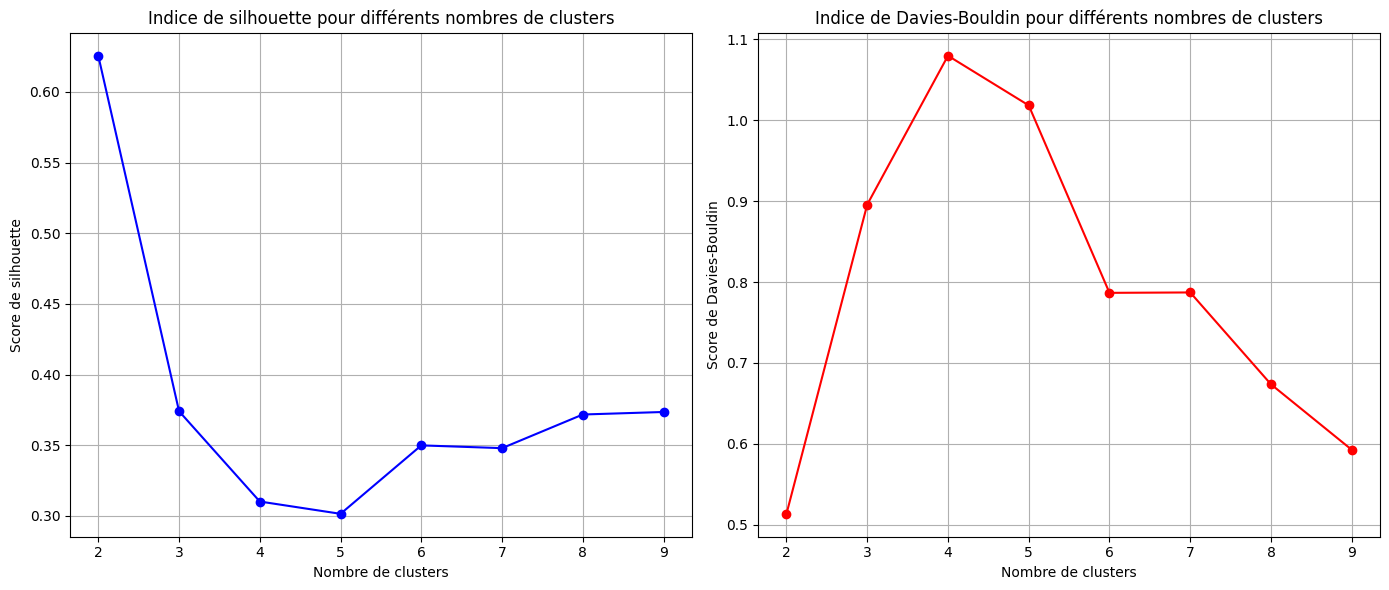

In [34]:

# Initialiser les listes pour stocker les scores
silhouette_scores = []
davies_bouldin_scores = []

# Parcourir les nombres de clusters de 2 à 9
for i in np.arange(2, 10):  # inclut 9
    # Appliquer KMeans avec i clusters
    clustering = KMeans(n_clusters=i, random_state=42).fit_predict(X_scaled)
    
    # Calculer l'indice de silhouette
    silhouette = metrics.silhouette_score(X_scaled, clustering, metric='euclidean')
    silhouette_scores.append(silhouette)
    
    # Calculer l'indice de Davies-Bouldin
    davies_bouldin = metrics.davies_bouldin_score(X_scaled, clustering)
    davies_bouldin_scores.append(davies_bouldin)
    
    # Afficher les scores pour cette partition
    print(f"KMeans avec {i} clusters :")
    print(f" - Indice de silhouette : {silhouette:.3f}")
    print(f" - Indice de Davies-Bouldin : {davies_bouldin:.3f}")
    print()

# Trouver les meilleurs scores
best_silhouette_idx = np.argmax(silhouette_scores) + 2  # Ajouter 2 car l'index 0 correspond à 2 clusters
best_davies_bouldin_idx = np.argmin(davies_bouldin_scores) + 2

print("Meilleure partition selon l'indice de silhouette :", best_silhouette_idx)
print("Meilleure partition selon l'indice de Davies-Bouldin :", best_davies_bouldin_idx)


# Visualisation des métriques
plt.figure(figsize=(14, 6))

# Silhouette index
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='blue')
plt.title("Indice de silhouette pour différents nombres de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Score de silhouette")
plt.grid()

# Davies-Bouldin index
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, davies_bouldin_scores, marker='o', color='red')
plt.title("Indice de Davies-Bouldin pour différents nombres de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Score de Davies-Bouldin")
plt.grid()

plt.tight_layout()
plt.show()


## Analyse des Résultats
***Indice de Silhouette :***

**Interprétation :** Plus ce score est élevé, meilleure est la séparation entre les clusters.
Le score est le plus élevé pour 2 clusters (0.626). Cela signifie que les données se séparent bien en deux groupes distincts.
Le score diminue à mesure que le nombre de clusters augmente, indiquant une diminution de la qualité de la séparation des clusters.

***Indice de Davies-Bouldin :***

**Interprétation :** Plus ce score est bas, meilleure est la séparation entre les clusters et plus les clusters sont compacts.
Le score est le plus faible pour 2 clusters (0.513), ce qui corrobore les observations de **l’indice de silhouette**.
Un score relativement faible est également observé pour 8 clusters (0.674) et 9 clusters (0.593), mais avec des indices de silhouette moins élevés.

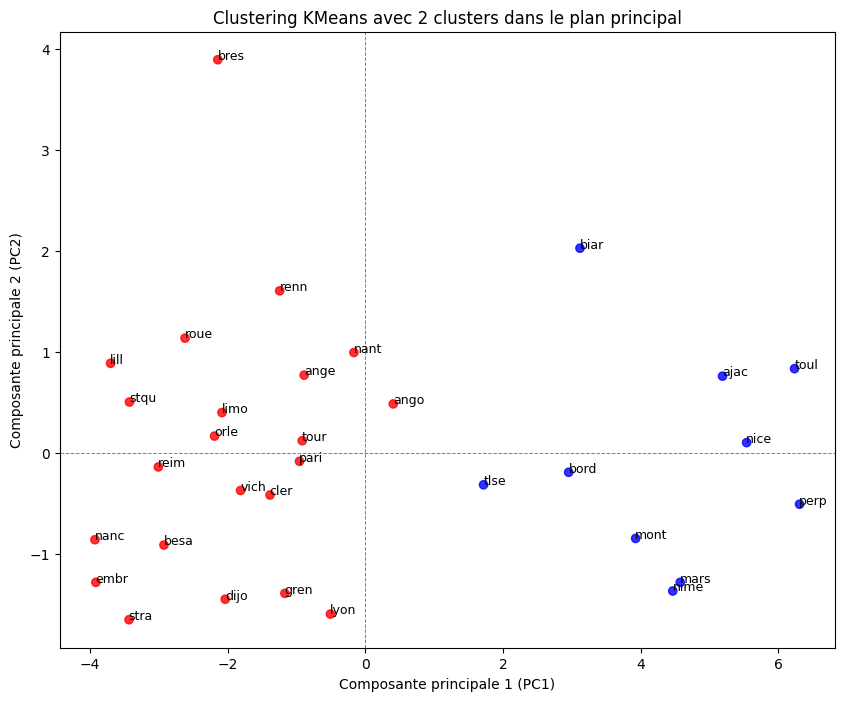

In [35]:
# Appliquer KMeans avec 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
clustering = kmeans.fit_predict(X_scaled)

# Visualisation des clusters dans le plan principal
colors = ['red', 'blue']
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustering, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.8)

# Ajouter les annotations (noms des villes)
for label, x, y in zip(labels, X_pca[:, 0], X_pca[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points', fontsize=9)

# Ajouter des lignes de référence et des informations au graphique
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)
plt.xlabel("Composante principale 1 (PC1)")
plt.ylabel("Composante principale 2 (PC2)")
plt.title("Clustering KMeans avec 2 clusters dans le plan principal")
plt.show()
